# Imports

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from helper_functions import print_structure
from torch.utils.data import DataLoader, TensorDataset

# Read data and pre-processing

In [2]:
shipsnet_path = "dataset/shipsnet.json"

with open(shipsnet_path) as f:
    data = json.load(f)

In [3]:
print_structure(data)

data: list
  list[4000]: list
    list[19200]: int
labels: list
  list[4000]: int
locations: list
  list[4000]: list
    list[2]: float
scene_ids: list
  list[4000]: str


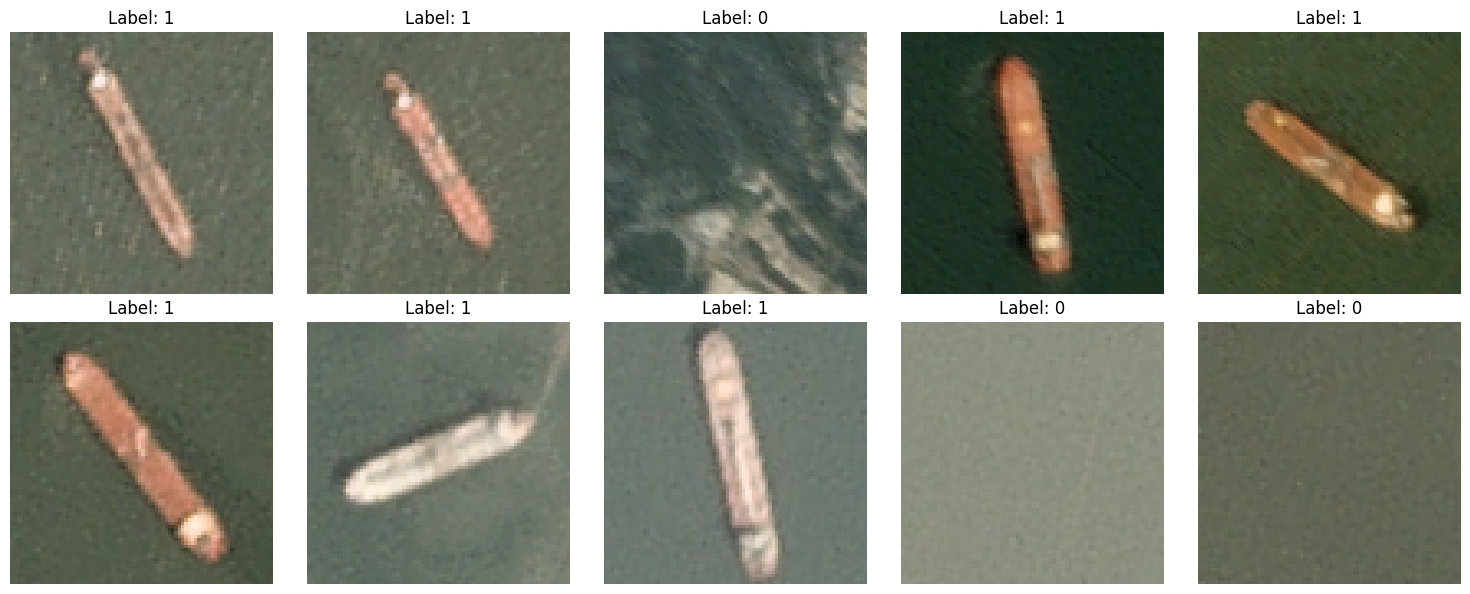

In [4]:
X_data = np.array(data["data"][:2000]) / 255.0
y_data = np.array(data["labels"][:2000])

X_data_transformed = X_data.reshape(-1, 3, 80, 80).transpose(0, 2, 3, 1)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
indices = np.random.randint(0, 2000, size=10)

for ax, idx in zip(axes.flat, indices):
    ax.imshow((X_data_transformed[idx] * 255).astype(np.uint8))
    ax.set_title(f"Label: {y_data[idx]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Train the model

In [5]:
from CNN import CNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

X_tensor = torch.tensor(X_data_transformed, dtype=torch.float32).permute(0, 3, 1, 2)
y_tensor = torch.tensor(y_data, dtype=torch.long)

# Split indices
num_samples = X_tensor.size(0)
train_size = int(0.8 * num_samples)
test_size = num_samples - train_size

indices = torch.randperm(num_samples)
train_idx, test_idx = indices[:train_size], indices[train_size:]

# Create splits
X_train, y_train = X_tensor[train_idx], y_tensor[train_idx]
X_test, y_test = X_tensor[test_idx], y_tensor[test_idx]

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


def rwg(x):
    return torch.maximum(torch.zeros_like(x), x * torch.exp(-(x**2)))


model = CNN(rwg, dropout_rate=0.5).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

best_loss = float("inf")

for epoch in range(1000):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = 100 * total_correct / total_samples

    print(f"Epoch {epoch + 1} completed, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    if avg_loss > best_loss * 1.2:
        print("Stopping early due to loss increase")
        break

    best_loss = min(best_loss, avg_loss)

# Test evaluation
model.eval()
test_correct = 0
test_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        test_correct += (preds == labels).sum().item()
        test_samples += labels.size(0)

test_accuracy = 100 * test_correct / test_samples
print(f"Test Accuracy: {test_accuracy:.2f}%")

cpu
Epoch 1 completed, Avg Loss: 0.6917, Accuracy: 53.50%
Epoch 2 completed, Avg Loss: 0.6681, Accuracy: 70.50%
Epoch 3 completed, Avg Loss: 0.5349, Accuracy: 75.50%
Epoch 4 completed, Avg Loss: 0.3281, Accuracy: 90.31%
Epoch 5 completed, Avg Loss: 0.1932, Accuracy: 95.38%
Epoch 6 completed, Avg Loss: 0.1418, Accuracy: 96.25%
Epoch 7 completed, Avg Loss: 0.1186, Accuracy: 96.69%
Epoch 8 completed, Avg Loss: 0.1017, Accuracy: 96.94%
Epoch 9 completed, Avg Loss: 0.0863, Accuracy: 97.44%
Epoch 10 completed, Avg Loss: 0.0714, Accuracy: 98.06%
Epoch 11 completed, Avg Loss: 0.0835, Accuracy: 97.69%
Epoch 12 completed, Avg Loss: 0.0672, Accuracy: 98.00%
Epoch 13 completed, Avg Loss: 0.0587, Accuracy: 98.44%
Epoch 14 completed, Avg Loss: 0.0542, Accuracy: 98.12%
Epoch 15 completed, Avg Loss: 0.0516, Accuracy: 98.25%
Epoch 16 completed, Avg Loss: 0.0479, Accuracy: 98.81%
Epoch 17 completed, Avg Loss: 0.0446, Accuracy: 98.69%
Epoch 18 completed, Avg Loss: 0.0409, Accuracy: 99.06%
Epoch 19 comple

# Initialise Framework

In [6]:
from seu_injection import StochasticSEUInjector
from seu_injection.metrics import classification_accuracy

injector = StochasticSEUInjector(trained_model=model, criterion=classification_accuracy, data_loader=test_loader)

Initialised version: 1.1.10
Testing a forward pass on cpu...
Baseline Criterion Score: 0.9875


# Run Framework

In [7]:
layer_info = {name: param.numel() for name, param in model.named_parameters()}
layers = list(layer_info.keys())
bit_indicies = [0, 1, 6, 15]
min_mean_flips = 10
print(layer_info)

{'conv1.weight': 216, 'conv1.bias': 8, 'conv2.weight': 1152, 'conv2.bias': 16, 'conv3.weight': 4608, 'conv3.bias': 32, 'fc1.weight': 1600, 'fc1.bias': 2}


In [8]:
all_results = pd.DataFrame()

for bit_i in bit_indicies:
    for layer_name in layers:
        params_in_layer = layer_info[layer_name]
        p = min(1, min_mean_flips / params_in_layer)

        results = injector.run_injector(bit_i=bit_i, layer_name=layer_name, p=p)
        results_df = pd.DataFrame(results)
        results_df["bit_i"] = bit_i
        all_results = pd.concat([all_results, results_df], ignore_index=True, axis=0)

Testing Layer: conv1.weight


Stochastic injection into conv1.weight: 216it [00:02, 76.34it/s] 


Testing Layer: conv1.bias


Stochastic injection into conv1.bias: 8it [00:02,  2.99it/s]


Testing Layer: conv2.weight


Stochastic injection into conv2.weight: 1152it [00:03, 352.95it/s]


Testing Layer: conv2.bias


Stochastic injection into conv2.bias: 16it [00:03,  5.30it/s]


Testing Layer: conv3.weight


Stochastic injection into conv3.weight: 4608it [00:02, 2147.06it/s]


Testing Layer: conv3.bias


Stochastic injection into conv3.bias: 32it [00:03,  8.24it/s]


Testing Layer: fc1.weight


Stochastic injection into fc1.weight: 1600it [00:02, 548.19it/s]


Testing Layer: fc1.bias


Stochastic injection into fc1.bias: 2it [00:00,  3.15it/s]


Testing Layer: conv1.weight


Stochastic injection into conv1.weight: 216it [00:03, 62.44it/s]


Testing Layer: conv1.bias


Stochastic injection into conv1.bias: 8it [00:02,  3.75it/s]


Testing Layer: conv2.weight


Stochastic injection into conv2.weight: 1152it [00:00, 1559.34it/s]


Testing Layer: conv2.bias


Stochastic injection into conv2.bias: 16it [00:03,  5.06it/s]


Testing Layer: conv3.weight


Stochastic injection into conv3.weight: 4608it [00:02, 1765.78it/s]


Testing Layer: conv3.bias


Stochastic injection into conv3.bias: 32it [00:02, 11.04it/s]


Testing Layer: fc1.weight


Stochastic injection into fc1.weight: 1600it [00:01, 962.11it/s]


Testing Layer: fc1.bias


Stochastic injection into fc1.bias: 2it [00:00,  3.42it/s]


Testing Layer: conv1.weight


Stochastic injection into conv1.weight: 216it [00:01, 122.44it/s]


Testing Layer: conv1.bias


Stochastic injection into conv1.bias: 8it [00:02,  3.07it/s]


Testing Layer: conv2.weight


Stochastic injection into conv2.weight: 1152it [00:04, 249.33it/s]


Testing Layer: conv2.bias


Stochastic injection into conv2.bias: 16it [00:02,  7.44it/s]


Testing Layer: conv3.weight


Stochastic injection into conv3.weight: 4608it [00:01, 2311.45it/s]


Testing Layer: conv3.bias


Stochastic injection into conv3.bias: 32it [00:03, 10.14it/s]


Testing Layer: fc1.weight


Stochastic injection into fc1.weight: 1600it [00:02, 650.04it/s]


Testing Layer: fc1.bias


Stochastic injection into fc1.bias: 2it [00:00,  4.26it/s]


Testing Layer: conv1.weight


Stochastic injection into conv1.weight: 216it [00:01, 206.20it/s]


Testing Layer: conv1.bias


Stochastic injection into conv1.bias: 8it [00:02,  3.43it/s]


Testing Layer: conv2.weight


Stochastic injection into conv2.weight: 1152it [00:00, 1308.24it/s]


Testing Layer: conv2.bias


Stochastic injection into conv2.bias: 16it [00:02,  6.11it/s]


Testing Layer: conv3.weight


Stochastic injection into conv3.weight: 4608it [00:04, 1148.39it/s]


Testing Layer: conv3.bias


Stochastic injection into conv3.bias: 32it [00:03,  9.17it/s]


Testing Layer: fc1.weight


Stochastic injection into fc1.weight: 1600it [00:03, 475.46it/s]


Testing Layer: fc1.bias


Stochastic injection into fc1.bias: 2it [00:00,  4.42it/s]


# Results Analysis

,tensor_location,criterion_score,layer_name,value_before,value_after,bit_i
0,"(0, 0, 0, 1)",0.9875,conv1.weight,-0.038231,0.038231,0
1,"(1, 0, 0, 1)",0.9850,conv1.weight,0.029864,-0.029864,0
2,"(2, 0, 0, 0)",0.9875,conv1.weight,0.075739,-0.075739,0
3,"(4, 2, 1, 2)",0.9875,conv1.weight,-0.184574,0.184574,0
4,"(5, 1, 0, 1)",0.9875,conv1.weight,0.023576,-0.023576,0
...,...,...,...,...,...,...
262,"(1, 299)",0.9875,fc1.weight,-0.130513,-0.129536,15
263,"(1, 485)",0.9875,fc1.weight,-0.044313,-0.044069,15
264,"(1, 791)",0.9875,fc1.weight,-0.024729,-0.024851,15
265,"(0,)",0.9875,fc1.bias,0.073400,0.073889,15


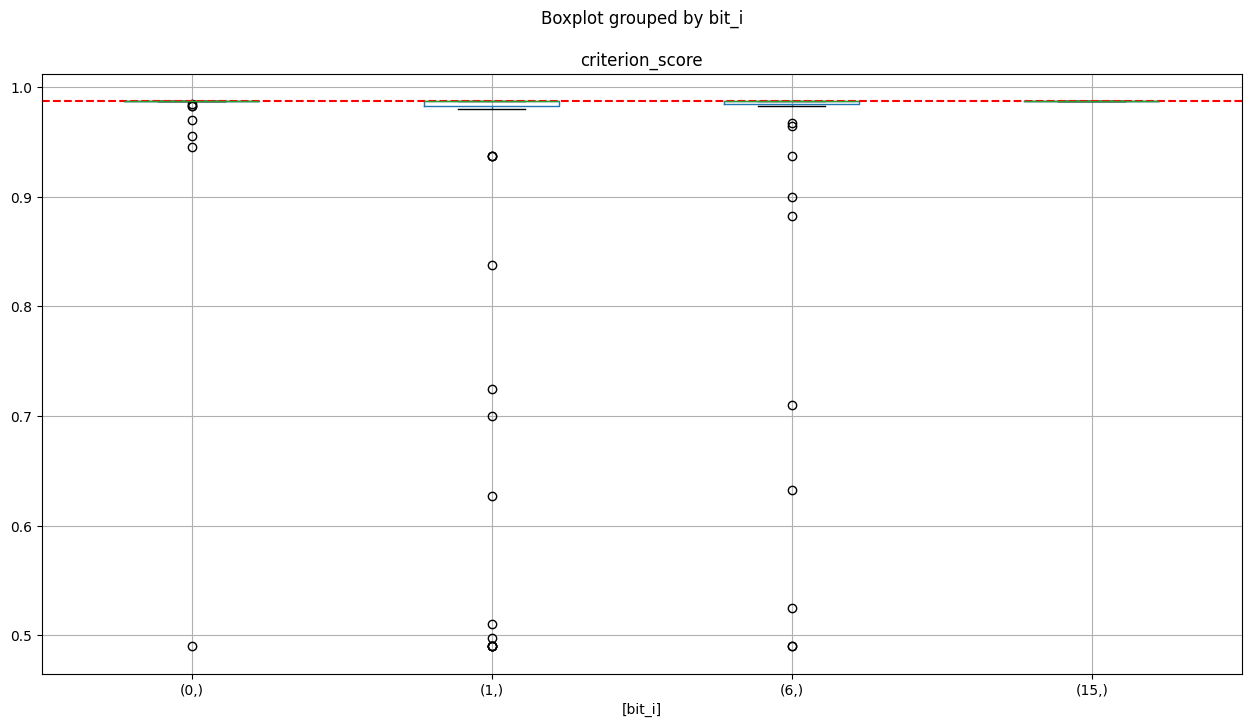

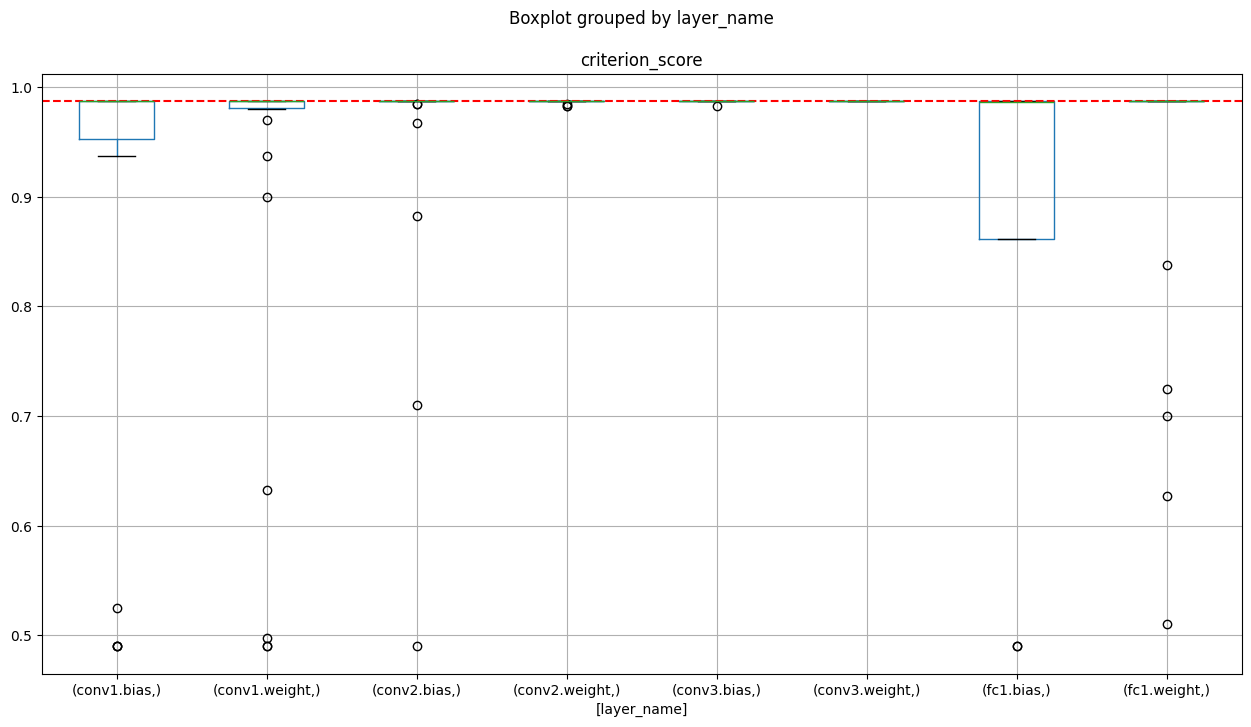

In [9]:
display(all_results)

all_results.boxplot(column="criterion_score", by=["bit_i"], figsize=(15, 8))
plt.axhline(injector.baseline_score, color="red", linestyle="--", label="Baseline Score")
all_results.boxplot(column="criterion_score", by=["layer_name"], figsize=(15, 8))
plt.axhline(injector.baseline_score, color="red", linestyle="--", label="Baseline Score")